# Cold-Chain Shipment Monitoring — Assignment Notebook

### Notebook roadmap
This notebook contains:
1. Problem statement & assumptions (Step 1)
2. Setup & imports (Step 2)
3. Data model / schema (Step 3)
4. Synthetic sample dataset generation (5 shipments × 10+ readings per sensor)
5. Data ingestion & validation
6. Violation detection functions (thresholds, spikes, sustained, correlation, gaps)
7. Shipment summary & risk scoring
8. Example outputs (JSON + plots)


## Step 1 — Notebook Front Matter (Title & Assumptions)

**Problem Context**

MediSafe Logistics ships temperature-sensitive medical supplies. Shipments must stay within defined temperature/humidity/health ranges. Each shipment is instrumented with sensors recording readings over time.

**Assumptions**
- Time resolution: readings every 5 minutes (synthetic data).
- Each shipment has the following sensors:
  - ThermoProbe T-100 (core temp)
  - TempTrack X5 (surface temp)
  - HumidSensor H-200 (humidity)
  - ShockLog S-50 (shock)
  - GPS ColdTrack G-12 (location)
  - BatteryMonitor B-10 (battery voltage)
- Thresholds (used later):
  - ThermoProbe T-100: 2°C – 8°C
  - TempTrack X5: 2°C – 10°C
  - HumidSensor H-200: 30% – 50% RH
  - ShockLog S-50: ≤ 5g
  - BatteryMonitor B-10: ≥ 3.2V
- Violation types: threshold breach, spike, sustained, correlated events, missing data.

**Deliverables**
- Data model / schema
- Rules & violation logic
- Sample dataset (5 shipments × 10+ readings/sensor)
- Shipment summary reports (JSON/table)
- Code implementation and example outputs


In [1]:
# Step 2 — Setup & Imports
import pandas as pd
import numpy as np
from datetime import timedelta
import random
import json
import math
import matplotlib.pyplot as plt

# Optional for nicer date formatting in plots
import matplotlib.dates as mdates

# Reproducibility
random.seed(42)
np.random.seed(42)

print("Libraries imported successfully ✅")

Libraries imported successfully ✅


## Step 3 — Data Model / Schema

Relational model:
- Shipments(shipment_id, origin, destination, start_time, end_time)
- Sensors(sensor_id, sensor_name, unit, threshold_min, threshold_max)
- Readings(reading_id, shipment_id, sensor_id, timestamp, value, lat, lon)
- Violations(violation_id, reading_id, violation_type, severity, notes)

Below we define the sensors metadata (useful for generating synthetic data and for threshold checks).


In [2]:
# Sensors metadata (schema-like structure)
SENSORS = [
    {"id":"T100","name":"ThermoProbe T-100","unit":"C","min":2.0,"max":8.0},
    {"id":"X5","name":"TempTrack X5","unit":"C","min":2.0,"max":10.0},
    {"id":"H200","name":"HumidSensor H-200","unit":"%","min":30.0,"max":50.0},
    {"id":"S50","name":"ShockLog S-50","unit":"g","min":0.0,"max":5.0},
    {"id":"G12","name":"GPS ColdTrack G-12","unit":"coords","min":None,"max":None},
    {"id":"B10","name":"BatteryMonitor B-10","unit":"V","min":3.2,"max":5.0},
]

import pandas as pd
pd.DataFrame(SENSORS)

,id,name,unit,min,max
0,T100,ThermoProbe T-100,C,2.0,8.0
1,X5,TempTrack X5,C,2.0,10.0
2,H200,HumidSensor H-200,%,30.0,50.0
3,S50,ShockLog S-50,g,0.0,5.0
4,G12,GPS ColdTrack G-12,coords,NaN,NaN
5,B10,BatteryMonitor B-10,V,3.2,5.0


## Step 4 — Generate Synthetic Sample Dataset
We will generate 5 shipments, each with 12 readings per sensor (5-minute interval). The generator will inject:
- A temperature spike
- A sustained temperature violation window
- A coincident shock event
- A low battery near the end
- One missing reading for variety


In [5]:
def generate_sample(n_shipments=5, readings_per_sensor=12, freq_min=5):
    rows=[]
    base_time = pd.Timestamp("2025-09-01 08:00")
    for s in range(1, n_shipments+1):
        shipment_id = 100 + s
        # simple starting lat/lon per shipment
        lat0 = 17.4 + 0.1*s
        lon0 = 78.4 - 0.1*s
        timestamps = pd.date_range(start=base_time + pd.Timedelta(days=s-1),
                                   periods=readings_per_sensor, freq=f'{freq_min}T')
        # baseline values
        T_base = 5.0 + np.random.normal(0, 0.3)
        X_base = 6.0 + np.random.normal(0, 0.4)
        H_base = 45.0 + np.random.normal(0, 1.0)
        shock_base = 0.3
        battery_base = 3.9
        # indices for injected events
        spike_idx = random.randint(2, readings_per_sensor-3)
        sustained_start = random.randint(1, readings_per_sensor-6)
        missing_idx = random.sample(range(readings_per_sensor), k=1)[0]
        for i, ts in enumerate(timestamps):
            lat = lat0 + 0.001*i + np.random.normal(0, 0.0002)
            lon = lon0 + 0.0015*i + np.random.normal(0, 0.0002)
            # ThermoProbe
            tval = T_base + np.random.normal(0, 0.2)
            if i == spike_idx:
                tval += 4.5  # spike
            if sustained_start <= i < sustained_start+3:
                tval = 9.5  # sustained > 8.0
            # TempTrack
            xval = X_base + np.random.normal(0, 0.3)
            if i == spike_idx:
                xval += 2.5
            # Humidity
            hval = H_base + np.random.normal(0, 1.0)
            if sustained_start <= i < sustained_start+2:
                hval = 60.0
            # Shock
            sval = shock_base + np.random.normal(0, 0.1)
            if i == spike_idx:
                sval = 6.5
            # Battery
            bval = battery_base - 0.05*(i/readings_per_sensor)
            if i > readings_per_sensor - 2:
                bval = 3.0
            # Inject missing reading by skipping ThermoProbe on some shipments
            if not (i == missing_idx and s % 2 == 0):
                rows.append({
                    "shipment_id": shipment_id,
                    "sensor_id": "T100",
                    "sensor_name": "ThermoProbe T-100",
                    "timestamp": ts,
                    "value": round(tval,2),
                    "unit": "C",
                    "lat": lat, "lon": lon
                })
            # other sensors
            rows.extend([
                {"shipment_id": shipment_id, "sensor_id": "X5", "sensor_name": "TempTrack X5", "timestamp": ts, "value": round(xval,2), "unit":"C", "lat":lat, "lon":lon},
                {"shipment_id": shipment_id, "sensor_id": "H200", "sensor_name": "HumidSensor H-200", "timestamp": ts, "value": round(hval,2), "unit":"%", "lat":lat, "lon":lon},
                {"shipment_id": shipment_id, "sensor_id": "S50", "sensor_name": "ShockLog S-50", "timestamp": ts, "value": round(sval,2), "unit":"g", "lat":lat, "lon":lon},
                {"shipment_id": shipment_id, "sensor_id": "G12", "sensor_name": "GPS ColdTrack G-12", "timestamp": ts, "value": None, "unit":"coords", "lat":lat, "lon":lon},
                {"shipment_id": shipment_id, "sensor_id": "B10", "sensor_name": "BatteryMonitor B-10", "timestamp": ts, "value": round(bval,2), "unit":"V", "lat":lat, "lon":lon},
            ])
    df = pd.DataFrame(rows)
    return df

sample_df = generate_sample()
sample_df.to_csv(r"C:\\Users\\hp\\Documents\\sample_data.csv", index=False)
print('Sample dataset created: C:\\Users\\hp\\Documents\\sample_data.csv')
sample_df.head(20)

Sample dataset created: C:\Users\hp\Documents\sample_data.csv


C:\Users\hp\AppData\Local\Temp\ipykernel_11036\2525178738.py:9: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  timestamps = pd.date_range(start=base_time + pd.Timedelta(days=s-1),


,shipment_id,sensor_id,sensor_name,timestamp,value,unit,lat,lon
0,101,T100,ThermoProbe T-100,2025-09-01 08:00:00,4.60,C,17.500438,78.299838
1,101,X5,TempTrack X5,2025-09-01 08:00:00,6.17,C,17.500438,78.299838
2,101,H200,HumidSensor H-200,2025-09-01 08:00:00,43.06,%,17.500438,78.299838
3,101,S50,ShockLog S-50,2025-09-01 08:00:00,0.25,g,17.500438,78.299838
4,101,G12,GPS ColdTrack G-12,2025-09-01 08:00:00,NaN,coords,17.500438,78.299838
5,101,B10,BatteryMonitor B-10,2025-09-01 08:00:00,3.90,V,17.500438,78.299838
6,101,T100,ThermoProbe T-100,2025-09-01 08:05:00,4.84,C,17.500848,78.301530
7,101,X5,TempTrack X5,2025-09-01 08:05:00,6.91,C,17.500848,78.301530
8,101,H200,HumidSensor H-200,2025-09-01 08:05:00,46.13,%,17.500848,78.301530
9,101,S50,ShockLog S-50,2025-09-01 08:05:00,0.24,g,17.500848,78.301530


## Step 5 — Data ingestion & validation

Load the generated CSV, parse timestamps, sort, and display basic info and missing values summary.


In [6]:
# Load and validate
df = pd.read_csv('C:\\Users\\hp\\Documents\\sample_data.csv', parse_dates=['timestamp'])
df = df.sort_values(['shipment_id','sensor_id','timestamp']).reset_index(drop=True)
df.info()
print('\nMissing values per column:')
print(df.isna().sum())
print('\nSample counts per shipment & sensor:')
print(df.groupby(['shipment_id','sensor_name']).size().unstack(fill_value=0))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 358 entries, 0 to 357
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   shipment_id  358 non-null    int64         
 1   sensor_id    358 non-null    object        
 2   sensor_name  358 non-null    object        
 3   timestamp    358 non-null    datetime64[ns]
 4   value        298 non-null    float64       
 5   unit         358 non-null    object        
 6   lat          358 non-null    float64       
 7   lon          358 non-null    float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(3)
memory usage: 22.5+ KB

Missing values per column:
shipment_id     0
sensor_id       0
sensor_name     0
timestamp       0
value          60
unit            0
lat             0
lon             0
dtype: int64

Sample counts per shipment & sensor:
sensor_name  BatteryMonitor B-10  GPS ColdTrack G-12  HumidSensor H-200  \
shipment_id               

## Step 6 — Violation detection functions

We implement:
- threshold violations
- spike detection
- sustained violation finder
- gap detection
- correlated event detection (e.g., shock + temp spike)


In [7]:
# Thresholds config (weights included for risk scoring)
THRESHOLDS = {
    "ThermoProbe T-100": {"min":2.0, "max":8.0, "unit":"C", "weight":0.40},
    "TempTrack X5": {"min":2.0, "max":10.0, "unit":"C", "weight":0.15},
    "HumidSensor H-200": {"min":30.0, "max":50.0, "unit":"%", "weight":0.15},
    "ShockLog S-50": {"min":0.0, "max":5.0, "unit":"g", "weight":0.15},
    "BatteryMonitor B-10": {"min":3.2, "max":5.0, "unit":"V", "weight":0.10},
}

def detect_threshold_violations(df, thresholds):
    df2 = df.copy()
    df2['violation'] = False
    df2['violation_type'] = None
    for sname, cfg in thresholds.items():
        mask = df2['sensor_name'] == sname
        vals = pd.to_numeric(df2.loc[mask,'value'], errors='coerce')
        low_mask = mask & (vals < cfg['min'])
        high_mask = mask & (vals > cfg['max'])
        df2.loc[low_mask, 'violation'] = True
        df2.loc[low_mask, 'violation_type'] = 'below_min'
        df2.loc[high_mask, 'violation'] = True
        df2.loc[high_mask, 'violation_type'] = 'above_max'
    return df2

def detect_spikes(df, delta_thresholds):
    df = df.sort_values(['shipment_id','sensor_name','timestamp']).copy()
    df['prev_val'] = df.groupby(['shipment_id','sensor_name'])['value'].shift(1)
    df['diff'] = (pd.to_numeric(df['value'], errors='coerce') - pd.to_numeric(df['prev_val'], errors='coerce')).abs()
    df['spike'] = False
    for sname, dt in delta_thresholds.items():
        df.loc[(df['sensor_name']==sname) & (df['diff'] > dt), 'spike'] = True
    return df

def detect_gaps(df, expected_freq_min=5, multiplier=3):
    gaps=[]
    for (sid, sname), g in df.groupby(['shipment_id','sensor_name']):
        g = g.sort_values('timestamp')
        diffs = g['timestamp'].diff().dt.total_seconds().div(60)
        median = diffs.median()
        threshold = (median if not np.isnan(median) else expected_freq_min) * multiplier
        big = g[diffs > threshold]
        for idx in big.index:
            gaps.append({'shipment_id':sid, 'sensor_name':sname, 'gap_after': g.loc[idx-1,'timestamp'], 'gap_until':g.loc[idx,'timestamp'], 'gap_minutes': diffs.loc[idx]})
    return pd.DataFrame(gaps)

def correlated_events(df, left_sensor, right_sensor, window_minutes=5):
    left = df[(df['sensor_name']==left_sensor) & ((df['violation']==True) | (df.get('spike', False)==True))].copy()
    right = df[(df['sensor_name']==right_sensor) & ((df['violation']==True) | (df.get('spike', False)==True))].copy()
    events=[]
    for _, l in left.iterrows():
        t = l['timestamp']
        ship = l['shipment_id']
        candidates = right[(right['shipment_id']==ship) & (right['timestamp'] >= (t - pd.Timedelta(minutes=window_minutes))) & (right['timestamp'] <= (t + pd.Timedelta(minutes=window_minutes)))]
        if not candidates.empty:
            for _, r in candidates.iterrows():
                events.append({'shipment_id':ship, 't_left':t, 'left_sensor':left_sensor, 't_right':r['timestamp'], 'right_sensor': right_sensor})
    return pd.DataFrame(events)

## Step 7 — Apply detection and compute shipment risk scores

We will:
- Detect threshold violations
- Detect spikes
- Detect gaps
- Find correlated events (shock + temp)
- Compute a weighted risk score per shipment


In [8]:
# Apply threshold detection
df_checked = detect_threshold_violations(df, THRESHOLDS)

# Detect spikes (example delta thresholds)
delta_thresh = {"ThermoProbe T-100":3.0, "TempTrack X5":2.0}
df_checked = detect_spikes(df_checked, delta_thresh)

# Detect gaps
gaps_df = detect_gaps(df_checked)

# Correlated events (shock with ThermoProbe)
corr_df = correlated_events(df_checked, 'ShockLog S-50', 'ThermoProbe T-100', window_minutes=5)

print('Violations detected:', df_checked['violation'].sum())
print('Spikes detected:', df_checked['spike'].sum())
print('\nGaps found:')
display(gaps_df.head())
print('\nCorrelated events (shock + temp):')
display(corr_df.head())

Violations detected: 39
Spikes detected: 26

Gaps found:


""



Correlated events (shock + temp):


,shipment_id,t_left,left_sensor,t_right,right_sensor
0,101,2025-09-01 08:25:00,ShockLog S-50,2025-09-01 08:20:00,ThermoProbe T-100
1,101,2025-09-01 08:25:00,ShockLog S-50,2025-09-01 08:25:00,ThermoProbe T-100
2,101,2025-09-01 08:25:00,ShockLog S-50,2025-09-01 08:30:00,ThermoProbe T-100
3,102,2025-09-02 08:10:00,ShockLog S-50,2025-09-02 08:10:00,ThermoProbe T-100
4,103,2025-09-03 08:40:00,ShockLog S-50,2025-09-03 08:40:00,ThermoProbe T-100


### Risk scoring

Weight sensors and compute sensor-level risk and overall shipment risk score. Map score to Low/Medium/High.


In [9]:
SEVERITY_MAP = {'below_min':2, 'above_max':2, 'spike':2, 'sustained':3, 'correlated':3, 'missing':2, None:1}

def compute_shipment_risk(df, thresholds):
    results=[]
    for ship, g in df.groupby('shipment_id'):
        sensor_scores={}
        for sname, sub in g.groupby('sensor_name'):
            total = len(sub)
            violations = int(sub['violation'].sum()) + int(sub.get('spike', pd.Series(False)).sum())
            if total == 0:
                sensor_risk = 0.0
            else:
                # approximate avg severity
                sev_vals = sub['violation_type'].map(SEVERITY_MAP).fillna(1)
                avg_sev = sev_vals.mean() if not sev_vals.empty else 1
                sensor_risk = min(1.0, (violations/total) * (avg_sev/3.0))
            weight = thresholds.get(sname, {}).get('weight', 0.05)
            sensor_scores[sname] = {'sensor_risk':round(sensor_risk,3), 'weight':weight, 'violations':violations, 'total':total}
        overall = sum(v['sensor_risk']*v['weight'] for v in sensor_scores.values())
        category = 'Low' if overall <= 0.3 else 'Medium' if overall <= 0.6 else 'High'
        results.append({'shipment_id':ship, 'risk_score':round(overall,3), 'risk_category':category, 'sensor_scores':sensor_scores})
    return pd.DataFrame(results)

risk_df = compute_shipment_risk(df_checked, THRESHOLDS)
risk_df.head()

,shipment_id,risk_score,risk_category,sensor_scores
0,101,0.110,Low,"{'BatteryMonitor B-10': {'sensor_risk': 0.03, ..."
1,102,0.154,Low,"{'BatteryMonitor B-10': {'sensor_risk': 0.03, ..."
2,103,0.144,Low,"{'BatteryMonitor B-10': {'sensor_risk': 0.03, ..."
3,104,0.134,Low,"{'BatteryMonitor B-10': {'sensor_risk': 0.03, ..."
4,105,0.144,Low,"{'BatteryMonitor B-10': {'sensor_risk': 0.03, ..."


## Step 8 — Shipment Summary Report (per shipment)

We compute per-sensor avg/min/max/std/count and list violations. The report will be exportable to JSON.


In [10]:
def shipment_summary(df, thresholds):
    summary_list=[]
    for ship, g in df.groupby('shipment_id'):
        per_sensor_stats = {}
        for sname, sub in g.groupby('sensor_name'):
            numeric = pd.to_numeric(sub['value'], errors='coerce').dropna()
            stats = {
                'avg': round(numeric.mean(),3) if not numeric.empty else None,
                'min': round(numeric.min(),3) if not numeric.empty else None,
                'max': round(numeric.max(),3) if not numeric.empty else None,
                'std': round(numeric.std(),3) if not numeric.empty else None,
                'count': int(len(sub)),
                'violations': int(sub['violation'].sum()) if 'violation' in sub else 0
            }
            per_sensor_stats[sname] = stats
        violations = g[(g['violation']==True) | (g.get('spike', False)==True)][['timestamp','sensor_name','value','violation_type','spike']].to_dict('records')
        summary_list.append({'shipment_id':int(ship), 'per_sensor':per_sensor_stats, 'violations':violations})
    return summary_list

summaries = shipment_summary(df_checked, THRESHOLDS)

# show one shipment sample report and save JSON
import json
json_path = 'C:\\Users\\hp\\Documents\\shipment_summary_example.json'
with open(json_path, 'w') as f:
    json.dump(summaries, f, default=str, indent=2)

print('Saved example JSON report to', json_path)
display(summaries[0])

Saved example JSON report to C:\Users\hp\Documents\shipment_summary_example.json


{'shipment_id': 101,
 'per_sensor': {'BatteryMonitor B-10': {'avg': 3.807,
   'min': 3.0,
   'max': 3.9,
   'std': 0.254,
   'count': 12,
   'violations': 1},
  'GPS ColdTrack G-12': {'avg': None,
   'min': None,
   'max': None,
   'std': None,
   'count': 12,
   'violations': 0},
  'HumidSensor H-200': {'avg': 47.312,
   'min': 43.06,
   'max': 60.0,
   'std': 6.06,
   'count': 12,
   'violations': 2},
  'ShockLog S-50': {'avg': 0.772,
   'min': 0.1,
   'max': 6.5,
   'std': 1.806,
   'count': 12,
   'violations': 1},
  'TempTrack X5': {'avg': 6.614,
   'min': 5.82,
   'max': 8.51,
   'std': 0.681,
   'count': 12,
   'violations': 0},
  'ThermoProbe T-100': {'avg': 6.407,
   'min': 4.6,
   'max': 9.5,
   'std': 2.271,
   'count': 12,
   'violations': 4}},
 'violations': [{'timestamp': Timestamp('2025-09-01 08:55:00'),
   'sensor_name': 'BatteryMonitor B-10',
   'value': 3.0,
   'violation_type': 'below_min',
   'spike': False},
  {'timestamp': Timestamp('2025-09-01 08:10:00'),
   'sen

## Step 9 — Example Visualization

Plot ThermoProbe time series for a sample shipment, marking violations.


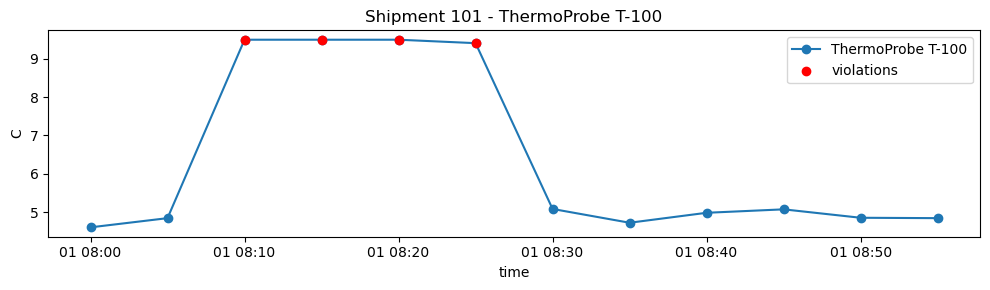

In [11]:
def plot_sensor_timeseries(df, shipment_id, sensor_name):
    sub = df[(df['shipment_id']==shipment_id) & (df['sensor_name']==sensor_name)].sort_values('timestamp')
    plt.figure(figsize=(10,3))
    plt.plot(sub['timestamp'], pd.to_numeric(sub['value'], errors='coerce'), marker='o', label=sensor_name)
    v = sub[sub['violation']==True]
    if not v.empty:
        plt.scatter(v['timestamp'], pd.to_numeric(v['value'], errors='coerce'), color='red', label='violations', zorder=5)
    plt.title(f'Shipment {shipment_id} - {sensor_name}')
    plt.xlabel('time')
    plt.ylabel(sub['unit'].iloc[0] if 'unit' in sub.columns else '')
    plt.legend()
    plt.tight_layout()
    plt.show()

# pick first shipment id from data
first_ship = df['shipment_id'].unique()[0]
plot_sensor_timeseries(df_checked, first_ship, 'ThermoProbe T-100')

## Final Remarks & Next steps

- The notebook includes core detection logic and a sample dataset.  
- For production: consider TimescaleDB for time-series storage, Kafka for ingestion, and a microservice architecture for real-time alerts.  
- Optional improvements: anomaly detection (IsolationForest), interactive dashboards (Streamlit/Plotly Dash), unit tests with pytest.
